# Steel defect detection with FastAI

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Steel-defect-detection-with-FastAI" data-toc-modified-id="Steel-defect-detection-with-FastAI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Steel defect detection with FastAI</a></span><ul class="toc-item"><li><span><a href="#Unet-with-ResNet18" data-toc-modified-id="Unet-with-ResNet18-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Unet with ResNet18</a></span><ul class="toc-item"><li><span><a href="#Training-128x800" data-toc-modified-id="Training-128x800-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Training 128x800</a></span></li><li><span><a href="#Fine-tuning-128x800" data-toc-modified-id="Fine-tuning-128x800-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Fine-tuning 128x800</a></span></li><li><span><a href="#Resize-and-training-256x1600" data-toc-modified-id="Resize-and-training-256x1600-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Resize and training 256x1600</a></span></li><li><span><a href="#Fine-tuning-256x1600" data-toc-modified-id="Fine-tuning-256x1600-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Fine-tuning 256x1600</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Unet-with-ResNet34" data-toc-modified-id="Unet-with-ResNet34-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Unet with ResNet34</a></span><ul class="toc-item"><li><span><a href="#Training-128x800" data-toc-modified-id="Training-128x800-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Training 128x800</a></span></li><li><span><a href="#Fine-tuning-128x800" data-toc-modified-id="Fine-tuning-128x800-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Fine-tuning 128x800</a></span></li><li><span><a href="#Resize-and-training-256x1600" data-toc-modified-id="Resize-and-training-256x1600-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Resize and training 256x1600</a></span></li></ul></li></ul></li><li><span><a href="#Interpretation" data-toc-modified-id="Interpretation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Interpretation</a></span></li><li><span><a href="#Export" data-toc-modified-id="Export-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Export</a></span></li><li><span><a href="#Old" data-toc-modified-id="Old-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Old</a></span></li></ul></div>

In [ ]:
from steel_segmentation.core import *
from steel_segmentation.data import *
from steel_segmentation.preprocessing import *
from steel_segmentation.models.dls import *
from steel_segmentation.models.metrics import *
from steel_segmentation.models.model import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

In [ ]:
fastai.__version__

'2.2.3'

In [ ]:
torch.__version__

'1.7.0'

In [ ]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Tue Jan 26 07:58:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P6000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   29C    P8     9W / 250W |      4MiB / 24449MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print_competition_data(models_dir)

models/ResNet18-Unet-256-stage1.pth
models/ResNet18_kaggle_class.pth
models/ResNet18-Unet-256-stage3.pth
models/.ipynb_checkpoints
models/ResNet34-Unet-128-stage3.pth
models/ResNet18_class.pt
models/kaggle_ResNet18-Unet.pth
models/ResNet34-Unet-128-stage2.5.pth
models/ResNet34-Unet-128-stage2.pth


## Unet with ResNet18

Training a Unet model with `resnet18` encoder with progressive resizing.

In [ ]:
# bs = 4 # 8 gb
bs = 16 # 16 gb
# bs = 32 # 24 gb
szs = (128, 800)

In [ ]:
dls = get_segmentation_dls(bs, szs)

In [ ]:
x, y = dls.one_batch()
type(x), type(y), x.shape, y.shape

(fastai.torch_core.TensorImage,
 fastai.torch_core.TensorMask,
 (16, 3, 128, 800),
 (16, 128, 800))

In [ ]:
arch = resnet18

In [ ]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

### Training 128x800

In [ ]:
# Loading classifier weights
encoder_path = models_dir / "ResNet18-2_class.pt"

In [ ]:
segmentation_learner.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

In [ ]:
# segmentation_learner.freeze()

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=1.4454397387453355e-05)

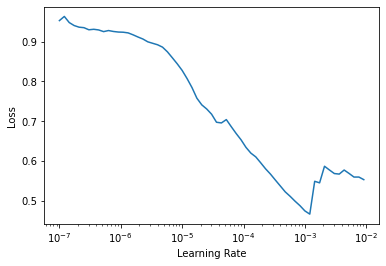

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
segmentation_learner.fit_one_cycle(10, lr_max=slice(1e-4, 7e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.077617,0.064304,0.400094,0.864774,07:18
1,0.073341,0.064050,0.395965,0.893417,07:17
2,0.068002,0.061350,0.531013,0.871681,07:14
3,0.055269,0.068252,0.472958,0.880891,07:13
4,0.054680,0.051352,0.545535,0.898572,07:13
5,0.050968,0.049561,0.571110,0.914313,07:12
6,0.048079,0.046953,0.564529,0.914444,07:12
7,0.044176,0.045532,0.641343,0.910027,07:12
8,0.042984,0.044673,0.666555,0.917361,07:12
9,0.039853,0.044556,0.673061,0.915163,07:12


In [ ]:
#segmentation_learner.save("ResNet18-Unet-128-stage1")

Path('models/ResNet18-Unet-stage1.pth')

In [ ]:
# stage2
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-4, 7e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.047727,0.050091,0.566619,0.915236,07:10
1,0.049110,0.051488,0.614058,0.889133,07:12
2,0.043920,0.045470,0.589829,0.918991,07:12
3,0.042332,0.043937,0.680346,0.920434,07:12
4,0.039790,0.042920,0.683014,0.923082,07:12


In [ ]:
#segmentation_learner.save("ResNet18-Unet-128-stage2")

Path('models/ResNet18-Unet-stage2.pth')

### Fine-tuning 128x800

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-128-stage2")

In [ ]:
segmentation_learner.validate()

(#3) [0.042923491448163986,0.6830139631164355,0.9230815172195435]

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=6.309573450380412e-07)

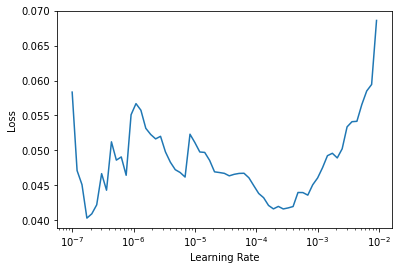

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage3
segmentation_learner.fit_one_cycle(10, lr_max=slice(2e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.042608,0.043629,0.685057,0.922095,10:06
1,0.043650,0.044138,0.688359,0.920928,10:05
2,0.042094,0.044083,0.694718,0.919718,10:05
3,0.038842,0.044115,0.684455,0.919441,10:05
4,0.040834,0.042209,0.695586,0.925560,10:06
5,0.038396,0.042617,0.703305,0.929716,10:06
6,0.035363,0.041282,0.713529,0.929295,10:05
7,0.032947,0.041631,0.719175,0.929696,10:05
8,0.034092,0.041418,0.724688,0.930014,10:05
9,0.034992,0.041048,0.727225,0.929578,10:05


In [ ]:
segmentation_learner.save("ResNet18-Unet-128-stage3")

Path('models/ResNet18-Unet-128-stage3.pth')

### Resize and training 256x1600

In [ ]:
# bs = 4 # 16 gb
bs = 8 # 24 gb

In [ ]:
orig_dls = get_segmentation_dls(bs, (256, 1600))
segmentation_learner.dls = orig_dls

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-128-stage3")

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=7.585775847473997e-07)

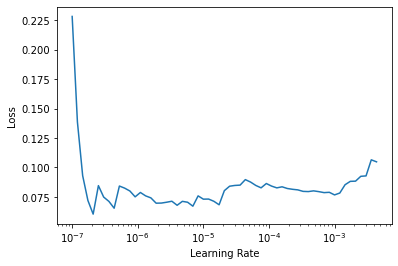

In [ ]:
segmentation_learner.lr_find()

In [ ]:
#stage1
segmentation_learner.fit_one_cycle(8, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.048108,0.048416,0.660539,0.897118,40:33
1,0.049675,0.046585,0.670772,0.908768,40:24
2,0.053268,0.048370,0.614278,0.904974,40:22
3,0.047116,0.046116,0.720387,0.905115,40:22
4,0.045527,0.048141,0.707756,0.905977,40:22
5,0.034245,0.051016,0.720741,0.910700,40:23
6,0.040398,0.046979,0.719904,0.917155,40:23
7,0.042392,0.046165,0.714892,0.914811,40:23


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
segmentation_learner.save("ResNet18-Unet-256-stage1")

Path('models/ResNet18-Unet-256-stage1.pth')

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-256-stage1")

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=2.75422871709452e-06)

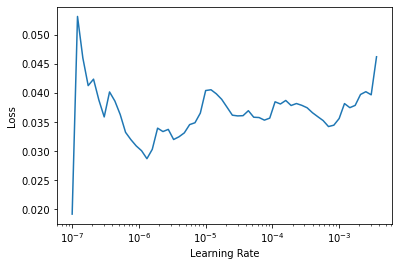

In [ ]:
segmentation_learner.lr_find()

In [ ]:
#stage2
segmentation_learner.fit_one_cycle(8, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.034535,0.045978,0.705646,0.922038,29:35
1,0.037973,0.048681,0.663536,0.926412,29:35
2,0.042783,0.043509,0.733397,0.916882,29:35
3,0.043034,0.043290,0.731311,0.918266,29:36


In [ ]:
segmentation_learner.save("ResNet18-Unet-256-stage2")

### Fine-tuning 256x1600

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet18-Unet-256-stage2")

In [ ]:
segmentation_learner.validate()

(#3) [0.0431373193860054,0.729721425655278,0.9257643222808838]

In [ ]:
segmentation_learner.unfreeze()

In [ ]:
orig_dls = get_segmentation_dls(bs, (256, 1600), with_btfms=False)
segmentation_learner.dls = orig_dls

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=6.309573450380412e-07)

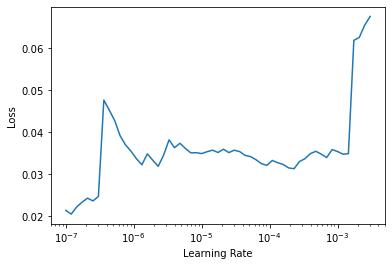

In [ ]:
segmentation_learner.lr_find()

In [ ]:
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.041420,0.044097,0.732492,0.902380,30:39
1,0.035430,0.043714,0.728829,0.921726,30:37
2,0.036363,0.041688,0.719019,0.923786,30:36
3,0.039209,0.041530,0.730980,0.927874,30:36
4,0.030240,0.042403,0.735394,0.926116,30:36


In [ ]:
segmentation_learner.save("ResNet18-Unet-256-stage3")

Path('models/ResNet18-Unet-256-stage3.pth')

### Results

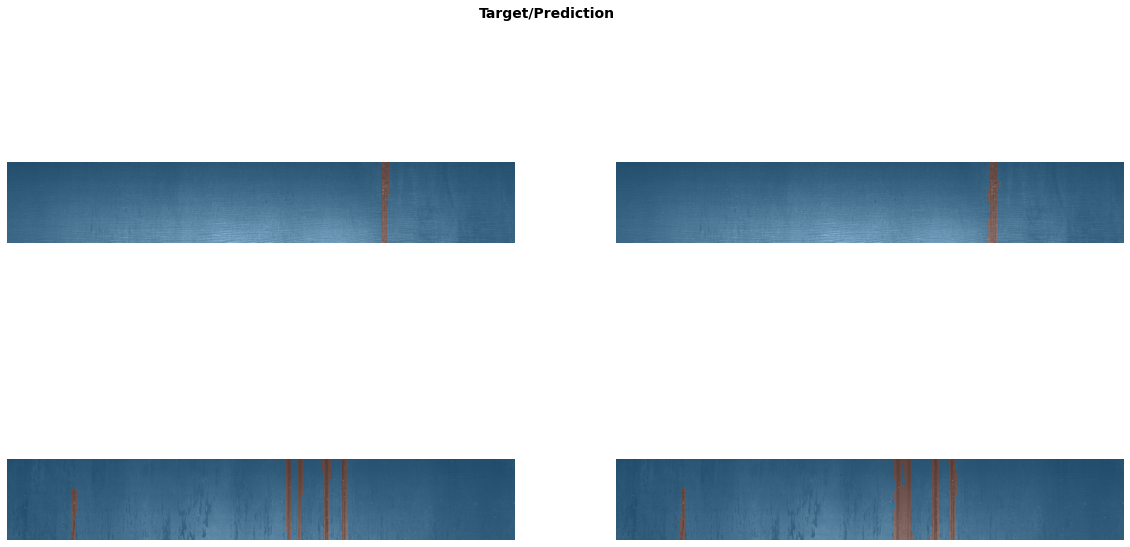

In [ ]:
segmentation_learner.show_results(figsize=(20,10))

## Unet with ResNet34

Training a Unet model with `resnet34` encoder with progressive resizing.

In [ ]:
# bs = 8 # 8 gb
# bs = 16 # 16 gb
bs = 32 # 24 gb
szs = (128, 800)

In [ ]:
dls = get_segmentation_dls(bs, szs)

In [ ]:
x, y = dls.one_batch()
type(x), type(y), x.shape, y.shape

(fastai.torch_core.TensorImage,
 fastai.torch_core.TensorMask,
 (32, 3, 128, 800),
 (32, 128, 800))

In [ ]:
arch = resnet34

In [ ]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

### Training 128x800

In [ ]:
encoder_path = Path("models") / "ResNet34_class.pt"

In [ ]:
segmentation_learner.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=6.30957365501672e-05)

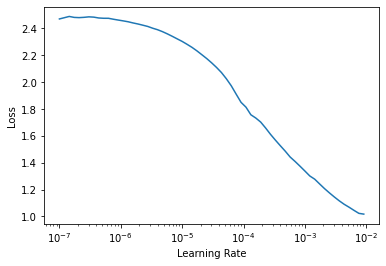

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
segmentation_learner.fit_one_cycle(10, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.096990,0.083665,0.313438,0.854797,10:19


In [ ]:
#segmentation_learner.save("ResNet34-Unet-128-stage1")

In [ ]:
segmentation_learner.validate()

(#3) [0.04473937675356865,0.5976832730043088,0.9188908338546753]

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=1.0964781722577754e-06)

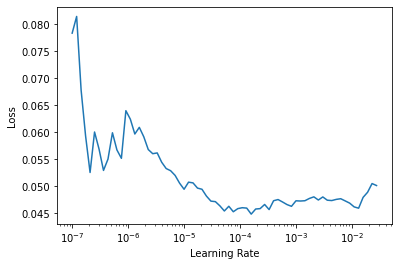

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage2
segmentation_learner.fit_one_cycle(5, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.046489,0.057221,0.510095,0.904385,10:19
1,0.050522,0.048390,0.576426,0.916290,10:17
2,0.048738,0.046528,0.605400,0.915738,10:17
3,0.041545,0.044939,0.670970,0.917952,10:17
4,0.038927,0.043841,0.695421,0.921191,10:17


In [ ]:
segmentation_learner.save("ResNet34-Unet-128-stage2")

Path('models/ResNet34-Unet-128-stage2.pth')

In [ ]:
segmentation_learner=segmentation_learner.load("ResNet34-Unet-128-stage2")

In [ ]:
# stage2
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time
0,0.056272,0.044763,0.680633,0.918842,07:42
1,0.054654,0.044657,0.696865,0.920368,07:34
2,0.050830,0.044335,0.694397,0.921019,07:34


### Fine-tuning 128x800

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=2.75422871709452e-06)

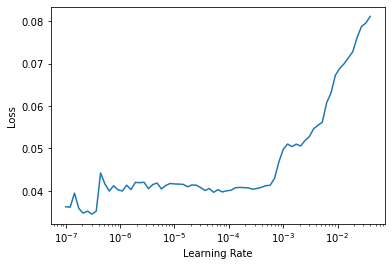

In [ ]:
segmentation_learner.lr_find()

In [ ]:
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.039433,0.043197,0.699255,0.922506,07:53
1,0.040728,0.043263,0.702246,0.921859,07:50
2,0.040855,0.042848,0.704515,0.921778,07:49
3,0.039050,0.042759,0.707800,0.924741,07:49
4,0.039491,0.042418,0.708120,0.924275,07:49


In [ ]:
segmentation_learner.save("ResNet34-Unet-128-stage3")

Path('models/ResNet34-Unet-128-stage3.pth')

### Resize and training 256x1600

In [ ]:
bs = 4 # 16 gb
# bs = 8 # 24 gb

In [ ]:
orig_dls = get_segmentation_dls(bs, (256, 1600))
segmentation_learner.dls = orig_dls

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-128-stage3")

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=6.309573450380412e-07)

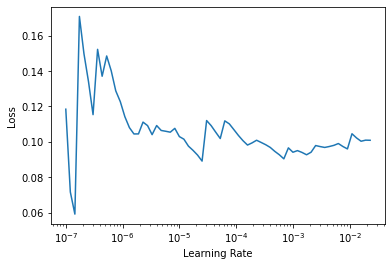

In [ ]:
segmentation_learner.lr_find()

In [ ]:
#stage1
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.059044,0.051117,0.659944,0.905373,43:05
1,0.056408,0.049172,0.548983,0.917324,42:57
2,0.042911,0.045532,0.692113,0.908705,43:15


In [ ]:
segmentation_learner.save("ResNet34-Unet-256-stage1")

# Interpretation

In [ ]:
# segmentation_learner.show_results(figsize=(20,10))

# Export

In [ ]:
!python notebook2script.py 03s_segmentation_model.ipynb

Converted 03s_segmentation_model.ipynb to exp/nb_03s.py


# Old

Here I select the training images from the `train` DataFrame with the images with some patterns (from this [kernel](https://www.kaggle.com/ateplyuk/detector-steels-with-texture/data) idea).

In [ ]:
pattern_imgs = ['000789191.jpg', '00d7ae946.jpg', '01b237ab8.jpg', '01d590c5f.jpg',
       '01e501f99.jpg', '023353d24.jpg', '031614d60.jpg', '03395a3da.jpg',
       '047681252.jpg', '063b5dcbe.jpg', '06a86ee90.jpg', '07cb85a8d.jpg',
       '07e8fca73.jpg', '08e21ba66.jpg', '092c1f666.jpg', '0a3bbea4d.jpg',
       '0a46cc4bf.jpg', '0a5a82b86.jpg', '0a65bd8d4.jpg', '0a76ac9b8.jpg',
       '0b3a0fabe.jpg', '0b50b417a.jpg', '0d0c21687.jpg', '0d22de6d4.jpg',
       '0e09ff3bd.jpg', '0e3ade070.jpg', '0e479a15f.jpg', '0ec90edd8.jpg',
       '0ef4bff49.jpg', '0faa71251.jpg', '0fab4b372.jpg', '0fac62a3e.jpg',
       '100de36e9.jpg', '109fbcecf.jpg', '110e63bfa.jpg', '11872c662.jpg',
       '11b60701f.jpg', '1205a8e2b.jpg', '12e5fd049.jpg', '12ef6188f.jpg',
       '13cf44f8d.jpg', '140c6ef91.jpg', '14b5ab5a6.jpg', '174528b1d.jpg',
       '175a25522.jpg', '175d95f92.jpg', '17a2d22f7.jpg', '17e6e4b30.jpg',
       '17e7e1e08.jpg', '18262cbbb.jpg', '1841b3825.jpg', '1844b698a.jpg',
       '184eb988e.jpg', '18af1ceb1.jpg', '18cc39190.jpg', '18cc78e81.jpg',
       '18dfcd9ae.jpg', '18e2f6396.jpg', '193732cc8.jpg', '194e207f7.jpg',
       '1a20228f6.jpg', '1a4ac4d43.jpg', '1a759ef19.jpg', '1aa7e1c47.jpg',
       '1bb316ba4.jpg', '1bec34f9a.jpg', '1c2b72b46.jpg', '1d4b011c7.jpg',
       '1d849ef03.jpg', '1dfd53dbb.jpg', '1e28fa5c3.jpg', '1e351863b.jpg',
       '1ee9359c6.jpg', '1f151ee84.jpg', '1f2c14ca8.jpg', '1f9f854f3.jpg',
       '1fcabeee5.jpg', '1fccd2eed.jpg', '1fd758653.jpg', '2059da9eb.jpg',
       '219cd030a.jpg', '21d2b3168.jpg', '220129a97.jpg', '223e550cc.jpg',
       '22757e90a.jpg', '22d94f944.jpg', '230ce1940.jpg', '2338ed2ae.jpg',
       '2441b5d16.jpg', '249b7d301.jpg', '255a79790.jpg', '25bc3a693.jpg',
       '26103f6a4.jpg', '26364af58.jpg', '26bcc93ff.jpg', '26e034336.jpg',
       '277c7771d.jpg', '27f331654.jpg', '2854206dc.jpg', '295e39efa.jpg',
       '2995f68a3.jpg', '29c3aaed7.jpg', '2a8096ad1.jpg', '2ab6eed56.jpg',
       '2acd6db1e.jpg', '2b06b596f.jpg', '2c14af3b2.jpg', '2c213b074.jpg',
       '2c67e770e.jpg', '2c8a82986.jpg', '2cf9289c4.jpg', '2d3c47b87.jpg',
       '2d7a69b1f.jpg', '2dd1084fb.jpg', '2e0ef2076.jpg', '2e4308ede.jpg',
       '2eb20e316.jpg', '2f2afbcc4.jpg', '2f473296b.jpg', '2fdafaf26.jpg',
       '303613d84.jpg', '3046d724c.jpg', '306415665.jpg', '30979541d.jpg',
       '329153502.jpg', '33691f767.jpg', '33a835109.jpg', '33e7b3469.jpg',
       '341952a36.jpg', '348bfe68e.jpg', '3503a107c.jpg', '3573170d7.jpg',
       '358e87349.jpg', '35d245aa8.jpg', '3615f1d69.jpg', '364e66340.jpg',
       '366248602.jpg', '36a630d2a.jpg', '374a718ca.jpg', '37f6b9fe0.jpg',
       '383793f65.jpg', '386a3b711.jpg', '386e34822.jpg', '387deae63.jpg',
       '3887e646f.jpg', '38fc3c6f5.jpg', '396851647.jpg', '3977fffae.jpg',
       '3996e2b5c.jpg', '39ac947b9.jpg', '3c0a7290f.jpg', '3c0b48018.jpg',
       '3c6c3dbf1.jpg', '3c9ce987e.jpg', '3d577cf47.jpg', '3e7d00bf4.jpg',
       '3f4cb099f.jpg', '3fdc767bf.jpg', '3feed5ab3.jpg', '404a89d7b.jpg',
       '405f55b63.jpg', '41ddf91f7.jpg', '422003263.jpg', '4281f5d71.jpg',
       '42e6b0f02.jpg', '44c7ae7bc.jpg', '44eaa8416.jpg', '453cb7bd8.jpg',
       '457055016.jpg', '45e2d90b0.jpg', '45f984c71.jpg', '467ba206c.jpg',
       '4687087d5.jpg', '47a0ed2bb.jpg', '47f4eb2de.jpg', '482e2e173.jpg',
       '4956b306e.jpg', '4a4c18443.jpg', '4a6a40fa0.jpg', '4c3e41efe.jpg',
       '4c40deb9a.jpg', '4c5617af0.jpg', '4d1aa2558.jpg', '4d39da061.jpg',
       '4d68a7a1a.jpg', '4d8fac53d.jpg', '4d9fadf79.jpg', '4e15a5ea4.jpg',
       '4e56a3dfc.jpg', '4ed62a0c0.jpg', '5047b4ba0.jpg', '508637e33.jpg',
       '50c83fcaf.jpg', '5122366c6.jpg', '512ac9a49.jpg', '5226a20da.jpg',
       '522ade1d3.jpg', '52b3b763f.jpg', '536f5bd1b.jpg', '54d5658e2.jpg',
       '55728df3e.jpg', '562e2274c.jpg', '57258d636.jpg', '578ba56db.jpg',
       '58499efc0.jpg', '5852d571b.jpg', '585f34f11.jpg', '58d6e5853.jpg',
       '59664a874.jpg', '59ae6ad57.jpg', '59ae6de0b.jpg', '59f53bdb4.jpg',
       '5a4af1a28.jpg', '5b3f3abe1.jpg', '5b4d883bf.jpg', '5ba431673.jpg',
       '5bbb8cea1.jpg', '5c5a0ce34.jpg', '5cd2a9b53.jpg', '5d070ece7.jpg',
       '5d34abcf4.jpg', '5ee800985.jpg', '5eeb58b97.jpg', '5f507f470.jpg',
       '5f7e6cfdd.jpg', '6006371fc.jpg', '602a29dac.jpg', '6100ef061.jpg',
       '614054f86.jpg', '617b8af67.jpg', '6181243e8.jpg', '6195c3cf0.jpg',
       '61a2a3de3.jpg', '625c1af1f.jpg', '62a4c01b4.jpg', '62cf0b008.jpg',
       '635c14be4.jpg', '64945c8c0.jpg', '64b0f37d7.jpg', '64b4c2791.jpg',
       '657f2e15d.jpg', '65829e956.jpg', '65e2c4248.jpg', '661f3fe2b.jpg',
       '665a8347a.jpg', '6724b9623.jpg', '682bdb9ca.jpg', '689491df4.jpg',
       '68db9ad2d.jpg', '692b061c7.jpg', '6951354ff.jpg', '6978ec041.jpg',
       '69b01f980.jpg', '69e3729fa.jpg', '6a09f4e4d.jpg', '6a8fbd4d1.jpg',
       '6b26c1a9a.jpg', '6b6497cef.jpg', '6b665ad9f.jpg', '6c2585cf5.jpg',
       '6ce483b03.jpg', '6ee81c40c.jpg', '6f0b6b59d.jpg', '6f19759f3.jpg',
       '6fc668134.jpg', '7018e55f6.jpg', '710a38fab.jpg', '719061f8f.jpg',
       '71b4288a5.jpg', '725d2e3da.jpg', '72682f66a.jpg', '7280c5e8d.jpg',
       '7303ad5de.jpg', '7311d533d.jpg', '74ec8e2a1.jpg', '75c290dc0.jpg',
       '761bdd88d.jpg', '764b4998b.jpg', '767755f3e.jpg', '7689b3227.jpg',
       '773d61c10.jpg', '774f60117.jpg', '775bddbe7.jpg', '77a034db9.jpg',
       '77d12abf0.jpg', '77dcba76f.jpg', '7868009d5.jpg', '788d11d35.jpg',
       '793b08f01.jpg', '794a1f622.jpg', '79631c4e2.jpg', '79b4672b2.jpg',
       '79b696401.jpg', '79f893f41.jpg', '7a835f759.jpg', '7b0b85b1d.jpg',
       '7b4be079e.jpg', '7b52c0c6c.jpg', '7bb17c5f2.jpg', '7c5b3e03a.jpg',
       '7c67a4611.jpg', '7cf827fc8.jpg', '7d4f862bf.jpg', '7db619168.jpg',
       '7e2607582.jpg', '7e5c4b68d.jpg', '7ed538f87.jpg', '7f98f8f6c.jpg',
       '802e8e4af.jpg', '8088f6b20.jpg', '80adf1a29.jpg', '811ed7a89.jpg',
       '813be2643.jpg', '818614bea.jpg', '822aa8de8.jpg', '82ac8152a.jpg',
       '8366a9a39.jpg', '8369f54aa.jpg', '83886dd5d.jpg', '85f750ca7.jpg',
       '86f7a8b1d.jpg', '870de47b5.jpg', '884bf0558.jpg', '888263bf8.jpg',
       '88b4105df.jpg', '88e6e44c1.jpg', '89c28225d.jpg', '8abee6870.jpg',
       '8b299d9aa.jpg', '8bba1760b.jpg', '8bcf692a1.jpg', '8bf89777a.jpg',
       '8bf8b9c33.jpg', '8c1825273.jpg', '8c7f9bc51.jpg', '8cceaf17c.jpg',
       '8cd4a4a89.jpg', '8dd5b0f4d.jpg', '90047b73a.jpg', '901b85944.jpg',
       '90b0043d9.jpg', '90b45e095.jpg', '90ed657c6.jpg', '9165be267.jpg',
       '916d55994.jpg', '918a753e9.jpg', '91f2a3209.jpg', '9207ba274.jpg',
       '92a84eb98.jpg', '930a3dc72.jpg', '94353a55a.jpg', '945200e71.jpg',
       '94a5728a6.jpg', '94f95f5ec.jpg', '955965785.jpg', '95e38ad8e.jpg',
       '96588d8eb.jpg', '96a82938c.jpg', '9719f1eba.jpg', '9766ccf1b.jpg',
       '976a099e9.jpg', '998d686d8.jpg', '9a08c2783.jpg', '9a2523ce9.jpg',
       '9a81a8056.jpg', '9aa44fa54.jpg', '9bac5408a.jpg', '9c05fdb53.jpg',
       '9ce34209d.jpg', '9d742f4b4.jpg', '9db428c2d.jpg', '9e26c5b98.jpg',
       '9e3aec0e0.jpg', '9edb5294f.jpg', '9efc711f5.jpg', '9f38e4503.jpg',
       '9f88a11c0.jpg', '9f8f010ab.jpg', '9ffe5113f.jpg', 'a09855d99.jpg',
       'a0b425852.jpg', 'a130c38e0.jpg', 'a1547cdfd.jpg', 'a27d1d567.jpg',
       'a2ff5d12e.jpg', 'a3339fb1b.jpg', 'a36c9a89e.jpg', 'a3fe8d17b.jpg',
       'a4a007ea2.jpg', 'a4dc8cd6c.jpg', 'a52aa70f7.jpg', 'a59a92ca2.jpg',
       'a61727238.jpg', 'a6f761c3f.jpg', 'a73cf6a39.jpg', 'a76da9e56.jpg',
       'a77935a71.jpg', 'a7f3a0644.jpg', 'a83442a46.jpg', 'a9bc755fe.jpg',
       'a9f605949.jpg', 'aa0ab8bf3.jpg', 'aa710b314.jpg', 'aa92ea82d.jpg',
       'aae7792ca.jpg', 'ab081e95e.jpg', 'ab13a6f37.jpg', 'ab1865ed6.jpg',
       'ab88df761.jpg', 'ac068dbec.jpg', 'ac9947293.jpg', 'ad9688790.jpg',
       'adcc1cac6.jpg', 'adf017a56.jpg', 'ae691a007.jpg', 'ae8e00590.jpg',
       'af1c8d7bb.jpg', 'af3692d16.jpg', 'af4e9bbc9.jpg', 'af9b9176f.jpg',
       'afcd4d5ee.jpg', 'b05584f2f.jpg', 'b0f641041.jpg', 'b17a3ba1b.jpg',
       'b1ad33d48.jpg', 'b2866fa08.jpg', 'b2b1349c7.jpg', 'b41f45416.jpg',
       'b43445f69.jpg', 'b4b6a1104.jpg', 'b56b55a7e.jpg', 'b688d23eb.jpg',
       'b6a5f38fa.jpg', 'b707e8c7b.jpg', 'b7cd8e6f3.jpg', 'b8fc355a4.jpg',
       'b9def70a3.jpg', 'ba1d5f5b5.jpg', 'ba5e54030.jpg', 'ba61430df.jpg',
       'ba8a923fa.jpg', 'bac478920.jpg', 'bae408bf0.jpg', 'bb52ff5d9.jpg',
       'bb78033f6.jpg', 'bbd271bd8.jpg', 'bbe88f4c8.jpg', 'bcbdbf3ac.jpg',
       'bd23fafce.jpg', 'bd5c85ced.jpg', 'bdf2e7b93.jpg', 'be3f5118b.jpg',
       'bf1683fdd.jpg', 'bf281e816.jpg', 'bfc7f2dfa.jpg', 'bff6601a3.jpg',
       'c0b79eb26.jpg', 'c1102118f.jpg', 'c130e2db0.jpg', 'c1e29d626.jpg',
       'c1e621914.jpg', 'c1ee793b9.jpg', 'c23ac4775.jpg', 'c27f43f5c.jpg',
       'c2a4d7a03.jpg', 'c2cff3176.jpg', 'c3c2bebd8.jpg', 'c4562eb61.jpg',
       'c521c444d.jpg', 'c54ee8ab4.jpg', 'c54f5ce35.jpg', 'c59bddadd.jpg',
       'c5cf9f24e.jpg', 'c633454bd.jpg', 'c645ee923.jpg', 'c6b51947f.jpg',
       'c6c8a3760.jpg', 'c70599c3a.jpg', 'c71cc5004.jpg', 'c88792f29.jpg',
       'c92d43a0f.jpg', 'c98cafcf4.jpg', 'c9c186f0b.jpg', 'cb1f7d883.jpg',
       'cc2a3d558.jpg', 'cc5f6debe.jpg', 'cd7186a59.jpg', 'cd8bf9803.jpg',
       'ce06d92b1.jpg', 'ceb4d3861.jpg', 'cebd47968.jpg', 'cececa61c.jpg',
       'cedd9ca39.jpg', 'cee644043.jpg', 'cf5df8ebd.jpg', 'cf78b36e0.jpg',
       'd0274160d.jpg', 'd07524f7c.jpg', 'd0c84eccb.jpg', 'd0f88f6d2.jpg',
       'd1267facd.jpg', 'd1517f67e.jpg', 'd19e7a3c2.jpg', 'd2391cadf.jpg',
       'd25a9387d.jpg', 'd3034da7a.jpg', 'd352c88ea.jpg', 'd37231205.jpg',
       'd3ba7a242.jpg', 'd3f297e2d.jpg', 'd43429032.jpg', 'd47afce21.jpg',
       'd4bd2a591.jpg', 'd501fc917.jpg', 'd5b0b7372.jpg', 'd6322390f.jpg',
       'd717541d8.jpg', 'd7af729ba.jpg', 'd7b5d31e5.jpg', 'd85e86732.jpg',
       'd86b4b652.jpg', 'd8c10c73f.jpg', 'd8e384009.jpg', 'd91c205e6.jpg',
       'd9285f64c.jpg', 'd97ec0357.jpg', 'd9845d7ae.jpg', 'dbbd64250.jpg',
       'dc3959c7b.jpg', 'dcd2b0763.jpg', 'dd3bf4f47.jpg', 'dd4364aa4.jpg',
       'ddb6adb93.jpg', 'de5f11a6b.jpg', 'de6d967a7.jpg', 'deca512a1.jpg',
       'df052e6d3.jpg', 'df233f70a.jpg', 'df997913a.jpg', 'e03364e95.jpg',
       'e0354613c.jpg', 'e0524919c.jpg', 'e1c960f0b.jpg', 'e2cc5ba4f.jpg',
       'e3228a3cf.jpg', 'e335e17b2.jpg', 'e38fb8774.jpg', 'e40347dd6.jpg',
       'e4173df9a.jpg', 'e4b71594a.jpg', 'e4d0d99fd.jpg', 'e4fefe327.jpg',
       'e523f2341.jpg', 'e54b50c33.jpg', 'e573261f9.jpg', 'e59ee3b8e.jpg',
       'e65c374a9.jpg', 'e66f146bd.jpg', 'e74522431.jpg', 'e7e3c3df2.jpg',
       'e7e8fd526.jpg', 'e81458200.jpg', 'e850c3a86.jpg', 'e8b114d2a.jpg',
       'e91f2be81.jpg', 'e943bbc5b.jpg', 'ecb2bea37.jpg', 'ecf1f5bb7.jpg',
       'ed0d0866c.jpg', 'eda0fd38d.jpg', 'ee3be2a71.jpg', 'ef6febf17.jpg',
       'ef96ba685.jpg', 'efb8d2080.jpg', 'efbe1db43.jpg', 'f157238ea.jpg',
       'f1a782eb5.jpg', 'f30cde286.jpg', 'f34262e93.jpg', 'f41c0d27c.jpg',
       'f4222bcd7.jpg', 'f4b95bb65.jpg', 'f6c9b6570.jpg', 'f6ff3d051.jpg',
       'f7202186a.jpg', 'f8981ac65.jpg', 'f8aa3fcc1.jpg', 'f8cdb7672.jpg',
       'f8e2dbdf4.jpg', 'f91d56c49.jpg', 'f939530e3.jpg', 'f95867a2b.jpg',
       'fb6ed1e5a.jpg', 'fd319a9a3.jpg', 'fdc7bc599.jpg', 'fde8b6a20.jpg',
       'ff18dded1.jpg', 'ff3bac947.jpg']

In [ ]:
def check_img_paths(name: str):
    path = train_path / name    
    return path.is_file()

for num, img_name in enumerate(pattern_imgs):
    if not check_img_paths(img_name):
        print(f"Img {img_nameme}, num {num} not found!")

In [ ]:
train_imgs_df = train["ImageId"].drop_duplicates().to_frame()
print(train_imgs_df.shape)
train_imgs_df.isna().any()

(6666, 1)


ImageId    False
dtype: bool

In [ ]:
pattern_imgs_df = pd.Series(pattern_imgs, name="ImageId").drop_duplicates().to_frame()
print(pattern_imgs_df.shape)
pattern_imgs_df.isna().any()

(598, 1)


ImageId    False
dtype: bool

In [ ]:
nohardneg_df = pd.merge(pattern_imgs_df, train_imgs_df, how='outer')
print(nohardneg_df.info())
# nohardneg_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7261 entries, 0 to 7260
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  7261 non-null   object
dtypes: object(1)
memory usage: 113.5+ KB
None


In [ ]:
common_imgs = pd.merge(pattern_imgs_df, train_imgs_df, how='inner')
common_imgs["ImageId"] = common_imgs["ImageId"].drop_duplicates()
common_imgs.head()

,ImageId
0,306415665.jpg
1,6ee81c40c.jpg
2,a9f605949.jpg


In [ ]:
# img_path = train_path/"306415665.jpg"
# Image.open(img_path)

In [ ]:
# img_path = train_path/"6ee81c40c.jpg"
# Image.open(img_path)

In [ ]:
# img_path = train_path/"a9f605949.jpg"
# Image.open(img_path)

In [ ]:
# bs = 16 # 8 gb
bs = 16 # 16 gb
size = (128,800)

In [ ]:
dls = get_df_dls(train_df=nohardneg_df, bs=bs, size=size)

In [ ]:
len(dls.train.dataset), len(dls.valid.dataset)

(5809, 1452)

In [ ]:
# dls.show_batch(figsize=(40,40))